In [31]:
import numpy as np
import cv2
import openslide
import matplotlib.pyplot as plt 
from skimage.filters import threshold_otsu, median
from skimage.morphology import binary_dilation

In [3]:
from pathlib import Path

global_dir = Path("D:/CAMELYON16/")
data_dir = global_dir / "data/"
normal_wsi_path = data_dir / "training/normal/"
tumor_wsi_path = data_dir / "training/tumor/"
tumor_mask_path = data_dir / "training/lesion_annotations/"

In [4]:
def read_wsi(directory):
    paths = directory.glob("*.png")
    wsi_images = []
    for path in paths:
        wsi_image = cv2.imread(str(path))
        if wsi_image is not None:
            wsi_images.append(wsi_image)
    return wsi_images

In [63]:
wsi_normal_images = read_wsi(normal_wsi_path)

In [69]:
def extract_tissue_with_boxes(rgb_image):
    # Convert RGB image to HSV
    hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    
    # Perform Otsu thresholding on Hue and Saturation channels
    hue_channel = hsv_image[:, :, 0]
    sat_channel = hsv_image[:, :, 1]
    otsu_thresh_hue = threshold_otsu(hue_channel)
    otsu_thresh_sat = threshold_otsu(sat_channel)
    binary_mask_hue = hue_channel <= otsu_thresh_hue
    binary_mask_sat = sat_channel <= otsu_thresh_sat

    # Create the Mask (Hue + Saturation channels)
    binary_mask = binary_mask_hue + binary_mask_sat

    # Mask improvements
    # Apply median filtering to remove spurious regions
    binary_mask = median(binary_mask, np.ones((7, 7)))
    # Dilate to add slight tissue buffer
    binary_mask = binary_dilation(binary_mask, np.ones((5, 5)))

    # Convert to uint8
    binary_mask = (binary_mask + 255).astype(np.uint8)

    # Find contours and create bounding boxes
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours if cv2.contourArea(contour) > 1000] # Filter small areas
    
    # Draw bounding boxes on the original image
    image_with_boxes = rgb_image.copy()
    for (x, y, w, h) in bounding_boxes:
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    return binary_mask, bounding_boxes, image_with_boxes

In [70]:
def display_images(images,num_to_display=5):
    plt.figure(figsize=(15, 12))
    for i in range(num_to_display):

        rgb_image = images[i]
        _, bounding_boxes, image_with_boxes= extract_tissue_with_boxes(rgb_image)

        plt.subplot(2, num_to_display, i + 1)
        plt.imshow(image_with_boxes)
        plt.title(f"Image {i+1} with Bounding Boxes")
        plt.axis('off')

        # Display tissue mask
        plt.subplot(2, num_to_display, num_to_display + i + 1)
        plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY), cmap='gray')  # Display grayscale version of original image
        for (x, y, w, h) in bounding_boxes:
            rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1)
            plt.gca().add_patch(rect)
        plt.title(f"Tissue Zones {i+1}")
        plt.axis('off')
    plt.show()

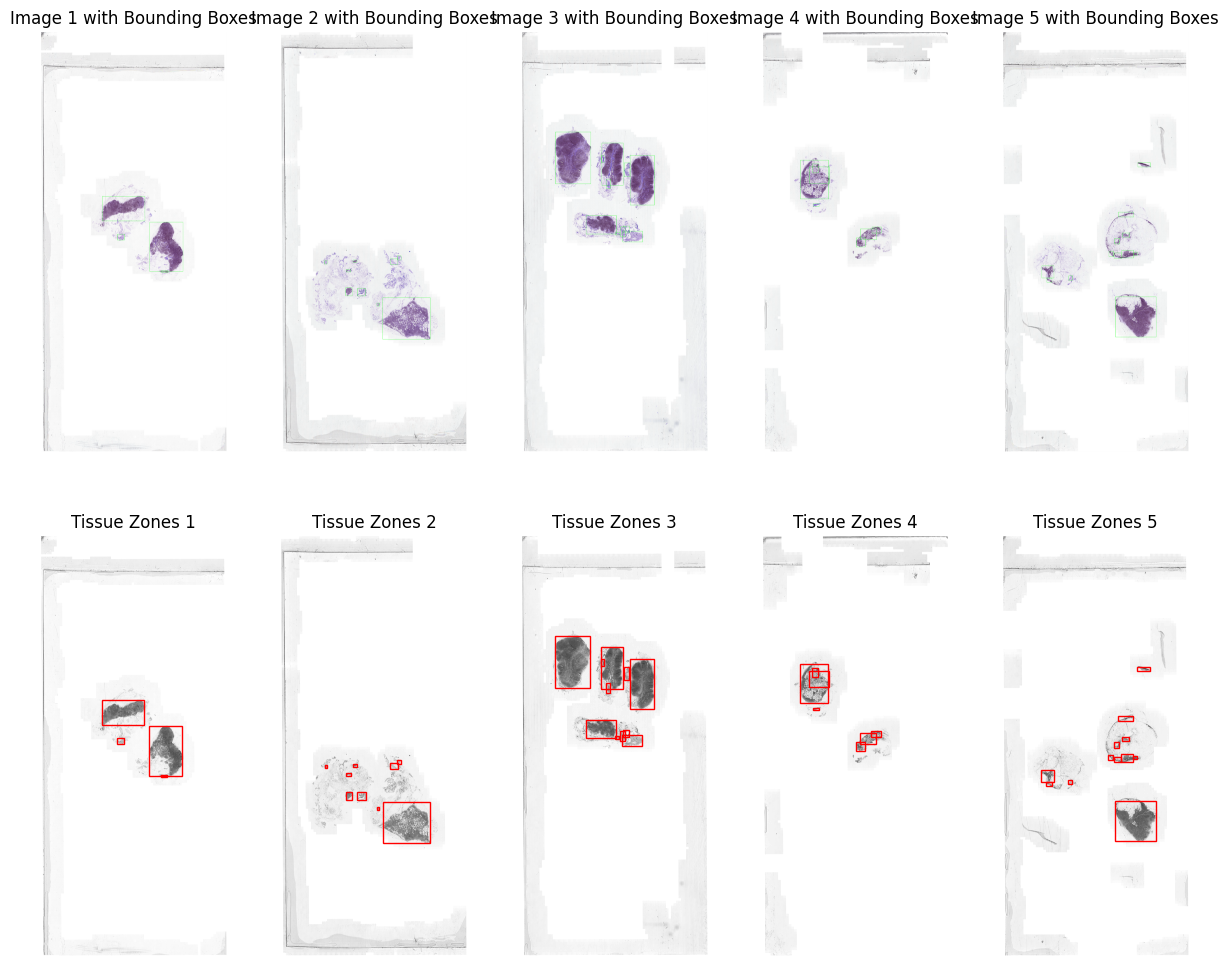

In [68]:
display_images(wsi_normal_images,5)

In [ ]:
# Example function to extract negative patches from normal WSI
def extract_negative_patches_from_normal_wsi(wsi_image, level_used, bounding_boxes, patch_save_dir, patch_prefix, patch_index):
    patch_size = 256  # Example patch size, adjust as needed
    
    for bbox in bounding_boxes:
        x, y, w, h = bbox
        
        # Calculate the number of patches that can fit within the bounding box
        num_patches_w = w // patch_size
        num_patches_h = h // patch_size
        
        for _ in range(10):  # Extract 10 patches per bounding box
            # Randomly choose patch coordinates within the bounding box
            patch_x = random.randint(x, x + w - patch_size)
            patch_y = random.randint(y, y + h - patch_size)
            
            # Read region from WSI and convert to RGB array
            patch_image = np.array(wsi_image.read_region((patch_x, patch_y), level_used, (patch_size, patch_size)).convert('RGB'))
            
            # Save patch image
            patch_path = f"{patch_save_dir}/{patch_prefix}_{patch_index}.png"
            cv2.imwrite(patch_path, cv2.cvtColor(patch_image, cv2.COLOR_RGB2BGR))
            patch_index += 1
    
    print(f"Patches saved in: {patch_save_dir}")
    return patch_index